# Task 2: Create a Predictive Algorithm

In your second task, you were expected to create model that classifies your labels that done in the first task.
Create a model by using Python or R. You are free to choose your algorithm and libraries / packages to use.

Finally, tune your hyper-parameters of your model by randomized search, grid search or any other search method and explain your reasoning for this choice.

---

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from utils.aux_functions import univariate_analysis, agg_assign

import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [2]:
# read data
df = pd.read_csv('./data/Courier_data.csv')

In [3]:
df.head()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_14,feature_15,feature_16,feature_17,lifetime_2,lifetime_1_a,lifetime_1_b,lifetime_1_c,lifetime_1_d,flag
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,...,0.8158,43.384804,1,19,33.0,0,1,0,0,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,...,0.8919,35.078042,3,11,33.0,0,1,0,0,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,...,0.9302,31.455285,1,10,33.0,0,1,0,0,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,...,0.7879,34.252991,1,30,33.0,0,1,0,0,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,...,0.8889,46.478114,1,4,35.0,1,0,0,0,0


In [4]:
df.shape

(3025, 25)

---

## Data Exploration

<h3 class="text-muted">Understanding the flag</h3>
> Our `flag` identifies couriers that did not work in weeks 9 to 11. Therefore, based on weekly observations, we are trying to __predict which couriers did not work in those 9 to 11 last weeks__.

The distribution of flags is relatively balanced (even though there are not so many observations)

In [5]:
flag = 'flag'

In [177]:
df[flag].value_counts()

0    1969
1    1056
Name: flag, dtype: int64

In [6]:
pd.DataFrame(
    { 
        'Count': df.groupby(flag)[flag].count(),
        'Percentage': df.groupby((flag)).size() / len(df), 
    }
)

,Count,Percentage
flag,,
0,1969,0.650909
1,1056,0.349091


The dataset is relatively small but not imbalanced. Since there is only a small set of observations the model can learn from, the risk of overfitting is significantly high. In order to obtain good results, it is necessary to keep in mind the following points:
* Reduce the complexity of the model to prevent overfitting the training dataset
* Bin continuous variables
* Reduce dimesionality (PCA, etc)

<h3 class="text-muted">Feature importance</h3>

Here we will focus our efforts on identifying good predictors.

<h6 class="text-muted">Correlation matrix</h6>

In [ ]:
# flag correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
k = 25 #number of variables for heatmap
cols = corrmat.nlargest(k, flag)[flag].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="RdBu", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h6 class="text-muted">Random Forest (feature importance)</h6>

In [7]:
features = df.columns[
        (~df.columns.str.contains(flag)) &
        (~df.columns.str.contains('courier'))
        ].values

In [8]:
from sklearn.ensemble import RandomForestClassifier

X = df[features].values
y = df[flag].values

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)

df_importances = pd.concat([
    pd.Series(features, name='feature'), 
    pd.Series(rnd_clf.feature_importances_, name='importance')]
    , axis=1)

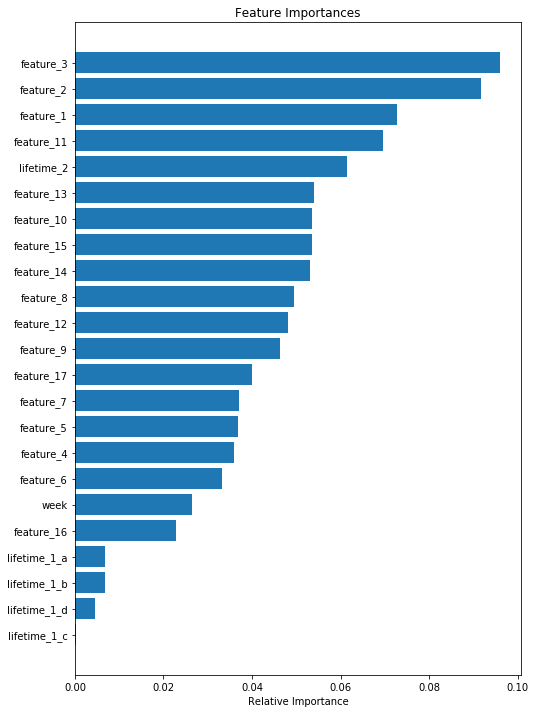

In [9]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

f, ax = plt.subplots(figsize=(8, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

<h6 class="text-muted">Univariate analysis</h6>

Let's now focus on performing an individual analysis for each of the most important features and evaluate how it works with our `flag`. To perform a univariate analysis, we will proceed to bin each feature and compare its distribution with the amount of flagged observations.

In small datasets, as explained before, it is good practice to bin continuous features to avoid overfitting. Therefore, the following univariate analysis is greatly useful at considering the binning technique for modelling later on. Through this analysis we also put our efforts into finding the right bins and assigning to each bin a _Weight of Evidence_ that can be of use in the modeling phase.

In [10]:
df_importance = pd.DataFrame([features[indices], importances[indices]]).transpose().rename(columns={0:'feature', 1:'importance'}).sort_values('importance', ascending=False)
df_importance.head(10)

,feature,importance
22,feature_3,0.0960483
21,feature_2,0.0916766
20,feature_1,0.072867
19,feature_11,0.0695556
18,lifetime_2,0.0615485
17,feature_13,0.0539035
16,feature_10,0.0535609
15,feature_15,0.0534575
14,feature_14,0.0531867
13,feature_8,0.049499


In [11]:
cols = np.append(features[indices][-8:], [flag])

In [ ]:
# flag correlation matrix
corrmat = df[cols].corr()
f, ax = plt.subplots(figsize=(6, 6))
k = len(cols) #number of variables for heatmap
cols = corrmat.nlargest(k, flag)[flag].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="RdBu", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h5 class="text-muted">feature_3</h5>

                % flag   n1    n
feature_3                       
(1.0, 24.0]          1  338  508
(24.0, 47.0]         0  380  842
(47.0, 70.0]         0  217  790
(70.0, 92.0]         0   98  521
(92.0, 115.0]        0   20  259
(115.0, 138.0]       0    3   77
(138.0, 161.0]       0    0   19
(161.0, 184.0]       0    0    9


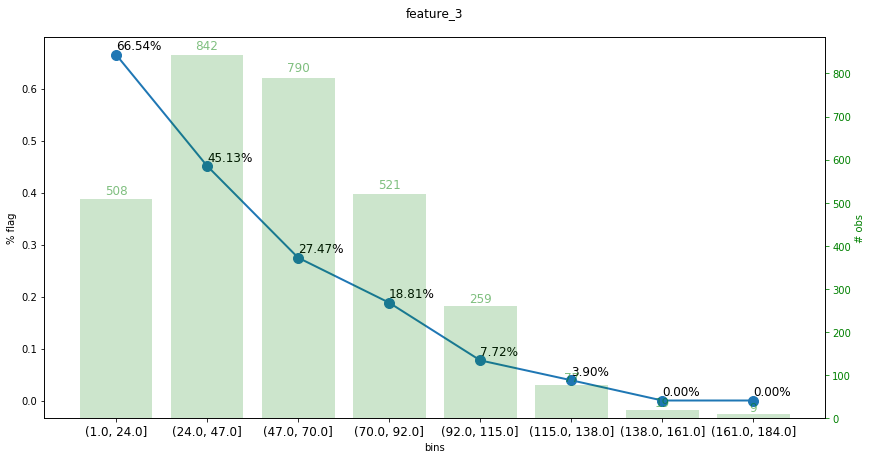

In [12]:
df = univariate_analysis(df, 'feature_3', flag, bins=8, woe=True, precision=0)

The tip provided "*distribution of feature_3 is a hint how the data is generated*" specially makes sense here when comparing this feature with the `flag` for each bin. We can clearly see that the first bucket (<=24) has the largest amount of `flag`. This means that these courier-week combinations correspond to couriers that did not work after the 9th week (`flag` = 1). Therefore, the larger the `feature_3`, the larger the chances those couriers worked in weeks 9 to 11. Conversely, the lower the `feature_3`, the lower the chances those couriers worked in last weeks of the time window.

Now let's examine why there is so much correlation between `feature_3` and `feature_11` and `feature_2`.

<h5 class="text-muted">feature_11</h5>

              % flag   n1    n
feature_11                    
(-0.0, 10.0]       1  446  729
(10.0, 20.0]       0  350  955
(20.0, 31.0]       0  194  812
(31.0, 41.0]       0   43  341
(41.0, 82.0]       0   23  188


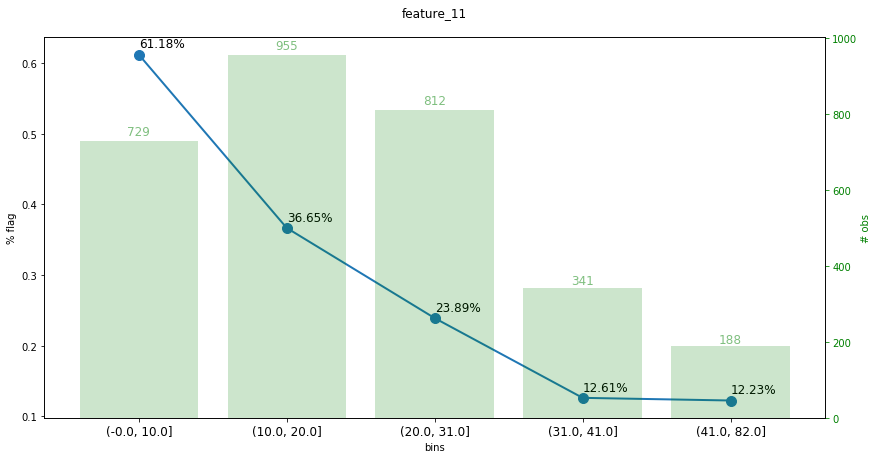

In [13]:
df = univariate_analysis(df, 'feature_11', flag, bins=[-0.1, 10, 20, 31, 41, 82], woe=True, precision=0)

<h5 class="text-muted">feature_2</h5>

                % flag   n1     n
feature_2                        
(1.0, 29.0]          1  554   949
(29.0, 57.0]         0  372  1326
(57.0, 85.0]         0  104   596
(85.0, 113.0]        0   15   117
(113.0, 141.0]       0    8    32
(141.0, 169.0]       1    3     5


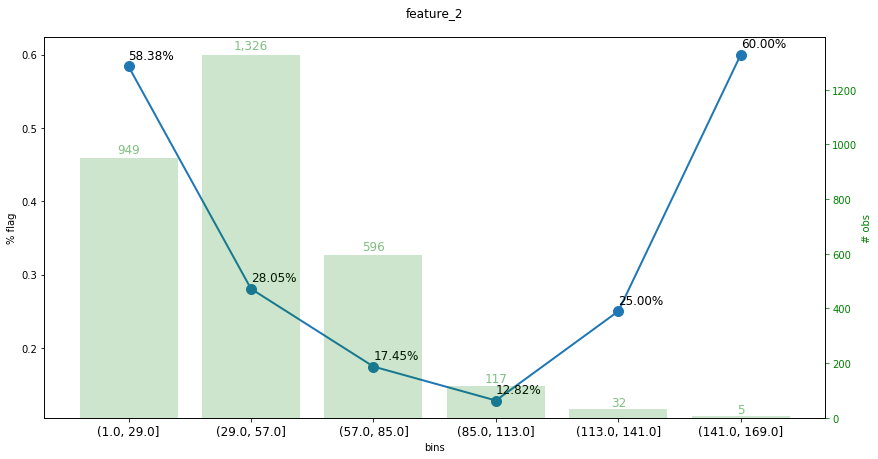

In [14]:
df = univariate_analysis(df, 'feature_2', flag, bins=6, woe=True, precision=0)

It can be clearly seen that correlations among these three features come from:

* The distribution of each feature follows the same pattern (__the majority of the population is concentrated in the first bins, usually with larger amount of flagged observations__).

<h5 class="text-muted">lifetime_2</h5>

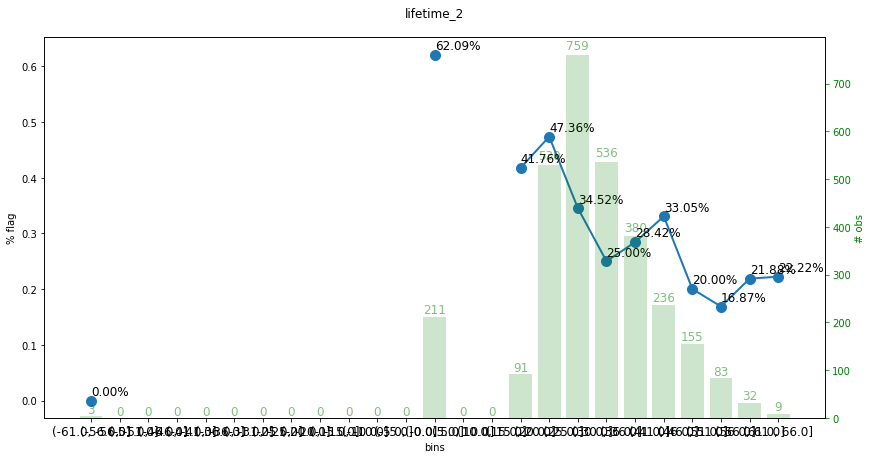

In [15]:
_ = univariate_analysis(df, 'lifetime_2', flag, bins=25, precision=0, detail=False); del _

There is high correlation between `feature_3`, `feature_11` and `feature_2`. It is interesting that `lifetime_2` is not correlated with these 3 features and has a relatively high importance with the `flag`. A more suitable binning is shown below.

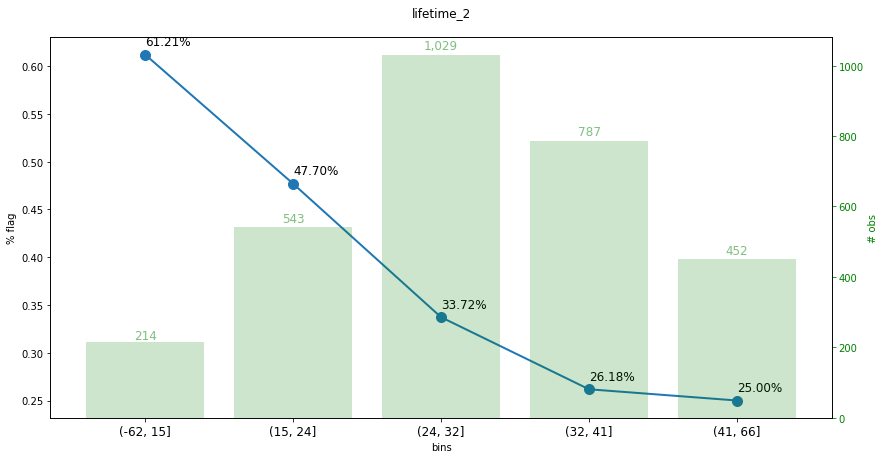

In [16]:
df = univariate_analysis(df, 'lifetime_2', flag, bins=[-62, 15, 24, 32, 41, 66], woe=True, precision=0, detail=False)

<h5 class="text-muted">feature_10</h5>

            % flag   n1     n
feature_10                   
(0, 6]           1   40    57
(6, 8]           0  141   350
(8, 10]          0  379  1338
(10, 12]         0  342   988
(12, 13]         0   68   146
(13, 15]         1   61   114
(15, 17]         1   15    21
(17, 25]         1   10    11


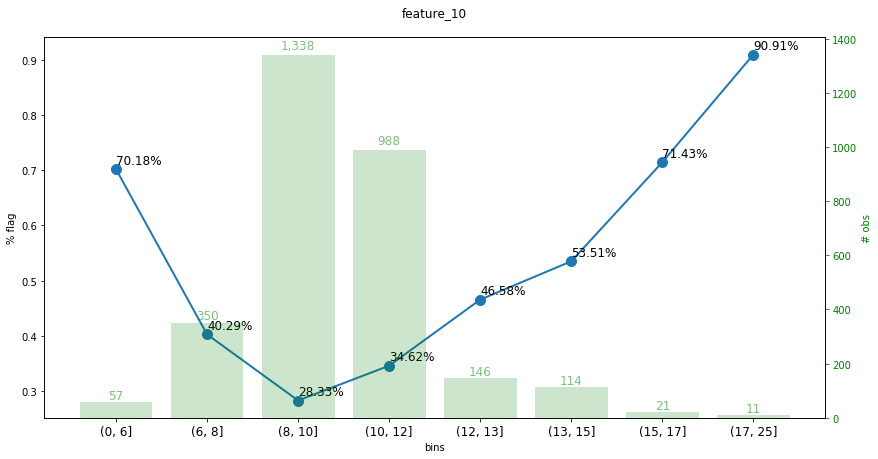

In [48]:
df = univariate_analysis(df, 'feature_10', flag, bins=[0, 6, 8, 10, 12, 13, 15, 17, 25], woe=True, precision=0)

In [49]:
df[df.columns[df.columns.str.contains('_woe')]].head(2).to_dict()

{'feature_10_woe': {0: -0.22946325278627594, 1: 0.012951152347077981},
 'feature_11_woe': {0: -1.0779096687497451, 1: -0.07574231082553656},
 'feature_2_woe': {0: 0.31873220280222114, 1: 0.31873220280222114},
 'feature_3_woe': {0: -0.42764397601161136, 1: -0.42764397601161136},
 'lifetime_2_woe': {0: 0.41383697368941147, 1: 0.41383697368941147}}

---

## Preprocessing

<h6 class="text-muted">Standardization</h6>

Necessary since there are features with completely different scales.

In [50]:
predictors = df_importances.sort_values('importance', ascending=False)['feature'].head(15).values

In [51]:
features = df.columns[
    ~df.columns.str.contains(flag) &
    ~df.columns.str.contains('courier') &
    ~df.columns.str.contains('week') &
    ~df.columns.str.contains('_bin') &
    ~df.columns.str.contains('_woe')
    ].values

<h6 class="text-muted">PCA to extract new features</h6>

Following the hint provided, new features (2) will be extracted from `feature_3` in combination with other ones. We will use PCA in an iterative way until we find the right combination of features such that the principal components have a large predictive power.

In [52]:
from sklearn.preprocessing import StandardScaler

all_predictors = features

scaler = StandardScaler()
df2 = pd.DataFrame(scaler.fit_transform(df[all_predictors]), columns=all_predictors)
df2[flag] = df[flag]
df2['courier'] = df['courier']

In [53]:
pca_features = df2.columns[df2.columns.str.contains('lifetime_1')].values

# Separating out the features
X = df2.loc[:, pca_features].values

# Separating out the target
y = df2[[flag]]

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [55]:
finalDf = pd.concat([principalDf, y], axis = 1)

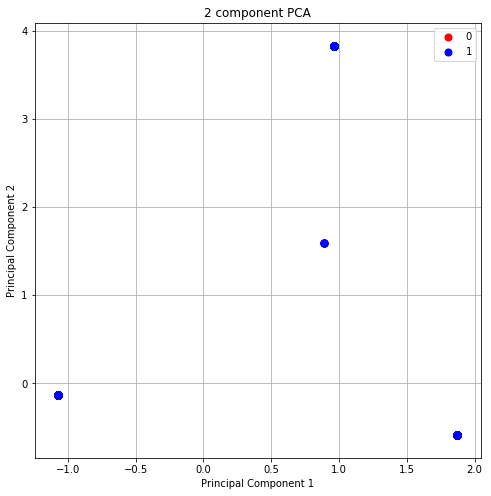

In [56]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 component PCA')
flags = [0,1]
colors = ['r','b']
for flag_, color in zip(flags,colors):
    indicesToKeep = finalDf[flag] == flag_
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(flags)
ax.grid()

In [57]:
df3 = pd.concat([df2, df[df.columns[df.columns.str.contains('_woe')]], finalDf[['PC1', 'PC2']]], axis=1)

In [58]:
# Choose all features except flag
# We will train / test split with more features (than predictors) so in case we want to try different features 
# in modelling, we can access them after splitting

features = df3.columns[
    ~df3.columns.str.contains(flag) &
    ~df3.columns.str.contains('courier') &
    ~df3.columns.str.contains('week') &
    ~df3.columns.str.contains('bin')
    ].values

X = df3[features].values
y = df3[flag].values

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify = y, random_state=42)

In [60]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (2722, 29)
X_test: (303, 29)
y_train: (2722,)
y_test: (303,)


In [61]:
train = pd.DataFrame(X_train, columns=[features])
train[flag] = list(y_train)

test = pd.DataFrame(X_test, columns=[features])
test[flag] = y_test

In [62]:
print("Train:", train.shape)
print("Test:", test.shape)

Train: (2722, 30)
Test: (303, 30)


Remove features not necessary for modelling:
* `courier`: not used to model since it is just an id (the model results would be definitely better but would not be realistic for production purposes).
* `feature_5`: we have seen that has complete negative correlation with `feature_4`.
* `lifetime_1`: already included in PCA features.

---
<h2>Model 1 <span class="text-muted">Lasso</span></h2>

In [109]:
list(df.columns[df.columns.str.contains('_woe')].values)

['feature_3_woe',
 'feature_11_woe',
 'feature_2_woe',
 'lifetime_2_woe',
 'feature_10_woe']

In [106]:
#predictors = [x for x in df3.columns if x not in ['flag', 'courier']]
predictors = df3.columns[
    ~df3.columns.str.contains(flag) &
    ~df3.columns.str.contains('courier') &
    ~df3.columns.str.contains('week') &
    ~df3.columns.str.contains('lifetime_1') &
    ~df3.columns.str.contains('_woe') &
    ~df3.columns.str.contains('_bin')
    ].values

In [110]:
predictors_optimal = [
    'feature_1', 
    'feature_3',
    'feature_8',
    'feature_16',
    'feature_2_woe',
    'feature_10_woe',
    'lifetime_2_woe',
    'PC1',
    'PC2'
]

In [157]:
from sklearn.linear_model import Lasso

def model_lasso(train, test, predictors):
    
    clf = Lasso(alpha=0.001, random_state=0)
    clf.fit(train[predictors].values, train[flag].values)

    print( "\nModel Report (Train)")
    print( "AUC Score: %f" % metrics.roc_auc_score(train[flag].values, clf.predict(train[predictors].values)))

    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(test[flag].values, clf.predict(test[predictors].values)))
       
    zipped = zip(list(predictors), clf.coef_)
    zipped = sorted(zipped, key=lambda x: abs(x[1]), reverse=True)

    print("\nList of predictors:")
    [print( ("%+d" % np.sign(predictor[1]))[0], "{:.2f}".format(abs(predictor[1])), predictor[0] ) for predictor in zipped]
    
    return clf

In [159]:
clf_lasso = model_lasso(train, test, predictors)


Model Report (Train)
AUC Score: 0.790388

Model Report (Test)
AUC Score: 0.777751

List of predictors:
- 0.15 feature_3
- 0.08 feature_1
- 0.05 feature_2
+ 0.03 feature_8
- 0.03 PC2
- 0.03 lifetime_2
+ 0.02 feature_13
+ 0.02 feature_11
+ 0.02 PC1
- 0.02 feature_7
- 0.01 feature_9
- 0.01 feature_16
- 0.00 feature_15
- 0.00 feature_17
- 0.00 feature_12
- 0.00 feature_6
- 0.00 feature_10
+ 0.00 feature_4
+ 0.00 feature_5
+ 0.00 feature_14


In [161]:
clf_lasso = model_lasso(train, test, predictors_optimal)


Model Report (Train)
AUC Score: 0.792775

Model Report (Test)
AUC Score: 0.782444

List of predictors:
- 0.11 feature_3
- 0.10 feature_2_woe
- 0.10 lifetime_2_woe
- 0.09 feature_1
- 0.08 feature_10_woe
+ 0.06 feature_8
- 0.04 PC2
+ 0.02 PC1
- 0.02 feature_16


In [ ]:
clf_lasso.predict(train[predictors])

In [116]:
model_lasso(train, test, predictors_optimal)


Model Report (Train)
AUC Score: 0.792775

Model Report (Test)
AUC Score: 0.782444

List of predictors:
- 0.11 feature_3
- 0.10 feature_2_woe
- 0.10 lifetime_2_woe
- 0.09 feature_1
- 0.08 feature_10_woe
+ 0.06 feature_8
- 0.04 PC2
+ 0.02 PC1
- 0.02 feature_16


---
<h2>Model 1 <span class="text-muted">Random Forest</span></h2>

In [164]:
def model_rnd(train, test, predictors):

    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    clf.fit(train[predictors].values, train[flag].values.ravel())

    print( "\nModel Report (Train)")
    print( "AUC Score: %f" % metrics.roc_auc_score(train[flag].values, clf.predict_proba(train[predictors].values)[:,1]))

    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(test[flag].values, clf.predict_proba(test[predictors].values)[:,1]))
       
    zipped = zip(list(predictors), clf.feature_importances_)
    zipped = sorted(zipped, key=lambda x: abs(x[1]), reverse=True)

    print("\nList of predictors:")
    [print( ("%+d" % np.sign(predictor[1]))[0], "{:.2f}".format(abs(predictor[1])), predictor[0] ) for predictor in zipped]
    
    return clf

In [165]:
clf_rnd = model_rnd(train, test, predictors)


Model Report (Train)
AUC Score: 1.000000

Model Report (Test)
AUC Score: 0.796451

List of predictors:
+ 0.10 feature_3
+ 0.09 feature_2
+ 0.07 feature_1
+ 0.07 feature_11
+ 0.06 lifetime_2
+ 0.06 feature_13
+ 0.06 feature_15
+ 0.06 feature_10
+ 0.05 feature_14
+ 0.05 feature_8
+ 0.05 feature_12
+ 0.05 feature_9
+ 0.04 feature_17
+ 0.04 feature_7
+ 0.04 feature_4
+ 0.04 feature_5
+ 0.03 feature_6
+ 0.02 feature_16
+ 0.01 PC2
+ 0.01 PC1


In [171]:
clf_rnd = model_rnd(train, test, predictors_optimal)


Model Report (Train)
AUC Score: 1.000000

Model Report (Test)
AUC Score: 0.792189

List of predictors:
+ 0.25 feature_3
+ 0.21 feature_8
+ 0.20 feature_1
+ 0.08 feature_2_woe
+ 0.08 lifetime_2_woe
+ 0.07 feature_10_woe
+ 0.06 feature_16
+ 0.02 PC2
+ 0.02 PC1


---
<h2>Model 3 <span class="text-muted">XGBoost</span></h2>

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

def modelfit(alg, 
             dtrain, 
             dtest, 
             predictors, 
             verbose=0, 
             useTrainCV=True, 
             cv_folds=5, 
             early_stopping_rounds=50, 
             target='flag'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values.flatten())
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=alg.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds, 
            verbose_eval=verbose)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg.get_params())
    
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target].values.flatten(),eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # Print model report:
    print( "\nModel Report (Train)")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print( "AUC Score: %f" % metrics.roc_auc_score(dtrain[target].values, dtrain_predprob))
    
    # Predict validation set:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]

    # Print model report:
    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(dtest[target].values, dtest_predprob))
    
    features_df = pd.DataFrame({'feature': pd.Series(predictors), 'importance': alg.feature_importances_})
    features_df = features_df.sort_values('importance', ascending=False)
    ind = np.arange(len(features_df['feature'].values))    # the x locations for the groups
    
    pyplot.figure(num=None, figsize=[12,4])
    pyplot.bar(range(len(features_df)), features_df['importance'].values)
    pyplot.xticks(ind, features_df['feature'].values, rotation='vertical')
    pyplot.ylabel('Feature Importance Score')
    pyplot.show()

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* __max_depth = 5:__ This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* __min_child_weight = 1:__ A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* __gamma = 0:__ A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* __subsample, colsample_bytree = 0.8:__ This is a commonly used used start value. Typical values range between 0.5-0.9.
* __scale_pos_weight = 1:__ Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take a low __learning rate of 0.1__ here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, test, predictors)

## GridSearch

We use GridSearch to find the optimal combination of hyperparameters. A search consists of:
* an estimator (regressor or classifier such as sklearn.svm.SVC());
* a parameter space;
* a method for searching or sampling candidates;
* a cross-validation scheme; and
* a score function.

<h6 class="text-muted">Step 1: Tune max_depth and min_child_weight</h6>

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [ ]:
from sklearn.model_selection import GridSearchCV #Perforing grid search

param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=False)

gsearch1.fit(train[predictors].values, train[target].values.flatten())

#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

There is high risk of overfitting for such large value for `max_depth`. Therefore, we are going to explore a narrower parameter space which should yield better results when generalising to test dataset.

In [ ]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=300,
        max_depth=5,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5, return_train_score=True)

gsearch2.fit(train[predictors].values,train[target].values.flatten())

#gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

In [ ]:
modelfit(gsearch2.best_estimator_, train, test, predictors)
gsearch2.best_params_, gsearch2.best_score_

The optimal values are `max_depth` = 5 and `min_child_weight` = 2, for now.

<h6 class="text-muted">Step 2: Tune gamma</h6>

Now let's tune gamma value using the parameters already tuned above. 

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch3.fit(train[predictors].values, train[target].values.flatten())

gsearch3.best_params_, gsearch3.best_score_

This shows that our original value of `gamma` = 0 was optimal. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, train, test, predictors)

Here, we can see the improvement in score. So the final parameters are:

* `max_depth`: 5
* `min_child_weight`: 2
* `gamma`: 0

Nonetheless, if we manually raise the value of `gamma` to 0.1 the results improve both in the train and test set.

In [ ]:
xgb2b = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2b, train, test, predictors)

<h6 class="text-muted">Step 3: Tune subsample and colsample_bytree</h6>

The next step would be try different `subsample` and `colsample_bytree` values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with. 

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch4.fit(train[predictors].values, train[target].values.flatten())

gsearch4.best_params_, gsearch4.best_score_

Here, we found 0.8 as the optimum value for `colsample_bytree` and 0.9 for `subsample`. Now we should try values in 0.05 interval around these.

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(80,95,5)],
 'colsample_bytree':[i/100.0 for i in range(80,95,5)]
}

gsearch5 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch5.fit(train[predictors].values, train[target].values.flatten())

gsearch5.best_params_, gsearch5.best_score_

In [ ]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, train, test, predictors)

The optimum values are:

* `subsample`: 0.90
* `colsample_bytree`: 0.85

However, 0.80 for both values works better.

<h6 class="text-muted">Step 4: Tuning Regularization Parameters</h6>

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as `gamma` provides a substantial way of controlling complexity. But we should always try it. I’ll tune `reg_alpha` value here and leave it upto you to try different values of `reg_lambda`.

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch6.fit(train[predictors].values, train[target].values.flatten())

gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb4, train, test, predictors)

<h6 class="text-muted">Step 5: Reducing the Learning Rate</h6>

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [ ]:
xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=2,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb5, train, test, predictors)

Reducing the `learning_rate` did no work as expected and the score reduced slightly.

<h6 class="text-muted">Saving the Model</h6>

In [ ]:
import pickle

# save model to file
pickle.dump(xgb4, open("xgb.pickle.dat", "wb"))

<h6 class="text-muted">Exporting data</h6>

In [ ]:
train['train'] = 1
test['train'] = 0

df_total = pd.concat([train, test]).reset_index().drop('index', axis=1)

In [ ]:
df_total.to_csv('./data/Courier_data_model.csv', sep=',', index=False)